In [1]:
import os
import sys 
os.chdir('..')
sys.path.insert(0, os.getcwd())
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K 
import glob

from Data_loader import load_subjects_from_json, base_folders, get_all_npy_paths_by_group
from AE_pipeline import (
    _parse_cycle,
    BATCH_SIZE,
    make_monolithic_ds,
    train_autoencoder,
    evaluate_and_detect,
    extract_and_save_latents,
    reconstruct_and_evaluate,
    parse_for_eval,
    write_labeled_tfrecord
)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
      accuracy_score, classification_report,
      adjusted_rand_score, normalized_mutual_info_score
)


2025-06-19 18:57:28.817595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-19 18:57:28.834893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-19 18:57:28.839621: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-19 18:57:28.852367: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-19 18:57:29.637231: W tensorflow/compiler/tf2

Mixed precision enabled


In [2]:
#Load  Train - Val - Test Dataset 
# Generar SHARDS para TRAIN 
shards_dir = "train_shards"
shard_files = sorted(glob.glob(os.path.join(shards_dir, "*.tfrecord.gz")))

# 3b) Pipeline shard-aware
train_ds = (
   tf.data.Dataset
      .list_files(shard_files, shuffle=True)
      .interleave(
         lambda f: tf.data.TFRecordDataset(f, compression_type="GZIP"),
         cycle_length=4,
         num_parallel_calls=tf.data.AUTOTUNE
      )
      .map(_parse_cycle, num_parallel_calls=tf.data.AUTOTUNE)
      #.repeat() # Evita out of range 
      .shuffle(5_000, seed=42)
      .batch(BATCH_SIZE, drop_remainder=True)
      .prefetch(tf.data.AUTOTUNE)
)

#Create VAL y TEST: dataset 

val_ds  = make_monolithic_ds("val_cycles.tfrecord.gz")
test_ds = make_monolithic_ds("test_cycles.tfrecord.gz")

print(f"→ train_ds: {train_ds}")
print(f"→ val_ds:   {val_ds}")
print(f"→ test_ds:  {test_ds}")

I0000 00:00:1750367572.004117   69431 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750367572.044402   69431 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750367572.044653   69431 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750367572.045827   69431 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

→ train_ds: <_PrefetchDataset element_spec=(TensorSpec(shape=(256, 100, 321), dtype=tf.float32, name=None), TensorSpec(shape=(256, 100, 321), dtype=tf.float32, name=None))>
→ val_ds:   <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 321), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 321), dtype=tf.float32, name=None))>
→ test_ds:  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 321), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 321), dtype=tf.float32, name=None))>


In [2]:
#Load the model 
def r2(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

model_path = 'saved_models/best_ae_Bi_256_tanh_lr1e4_50ep_AdamW.keras'  
model = load_model(
    model_path,
    custom_objects={'r2': r2},
    compile=False
)

I0000 00:00:1750370255.400185   92640 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750370255.441300   92640 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750370255.441512   92640 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750370255.442656   92640 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [ ]:
# OPTIONAL Show model summary and layers 
for layer in model.layers:
    print(layer.name)
model.summary()

ae_input
encoder_bilstm
bottleneck_dense
bottleneck_repeat
decoder_bilstm
decoder_output


Model: "BiLSTM_AE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 100, 321)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bilstm (Bidirectional)  │ (None, 512)            │     1,183,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck_dense (Dense)        │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck_repeat               │ (None, 100, 256)       │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bilstm (Bidirectional)  │ (None, 100, 512)       │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 100, 321)       │       164,673 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,530,369 (9.65 MB)

 Trainable params: 2,530,369 (9.65 MB)

 Non-trainable params: 0 (0.00 B)

# Evaluation and reconstruction 

In [4]:
#Compile the model 
model.compile(
    optimizer=tf.keras.optimizers.AdamW(),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(), r2]
)

In [ ]:
#Evaluation
all_losses, threshold = evaluate_and_detect(model, test_ds)

2025-06-19 14:17:22.027583: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1641] failed to alloc 134217728 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2025-06-19 14:17:22.027612: W external/local_xla/xla/stream_executor/integrations/device_host_allocator.h:61] could not allocate pinned host memory of size: 134217728
2025-06-19 14:17:23.059340: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1641] failed to alloc 268435456 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2025-06-19 14:17:23.059588: W external/local_xla/xla/stream_executor/integrations/device_host_allocator.h:61] could not allocate pinned host memory of size: 268435456
2025-06-19 14:17:23.439484: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1641] failed to alloc 241592064 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2025-06-19 14:17:23.439515: W external/local_xla/xla/stream_executor/integrations/device_host_allocator.h:61] could not allocate 

Test reconstruction MSE: 0.538095


2025-06-19 14:17:51.968331: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32870400 exceeds 10% of free system memory.
2025-06-19 14:17:51.968377: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32870400 exceeds 10% of free system memory.
2025-06-19 14:17:52.002589: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16435200 exceeds 10% of free system memory.
2025-06-19 14:17:52.023579: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16435200 exceeds 10% of free system memory.
2025-06-19 14:17:52.035790: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16435200 exceeds 10% of free system memory.


KeyboardInterrupt: 

In [ ]:
#Save Latent characteristics to npy 
latents = extract_and_save_latents(model, test_ds, output_path="latent_features_test.npy")

Saved latent features to latent_features_test.npy, shape (35115, 512)


2025-06-19 16:15:06.066205: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
# Build the encoder 
encoder = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer("bottleneck_dense").output
)


In [4]:
#Build the decoder 
latent_dim = model.get_layer("bottleneck_dense").units
# 
decoder_input = Input(shape=(latent_dim,), name="decoder_input")
# 
x = decoder_input
x = model.get_layer("bottleneck_repeat")(x)    # RepeatVector(100)
x = model.get_layer("decoder_bilstm")(x)       # Bidirectional LSTM
x = model.get_layer("decoder_output")(x)       # TimeDistributed(Dense(321))
# 
decoder = Model(decoder_input, x, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck_repeat               │ (None, 100, 256)       │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bilstm (Bidirectional)  │ (None, 100, 512)       │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 100, 321)       │       164,673 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,215,297 (4.64 MB)

 Trainable params: 1,215,297 (4.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Reconstruct and evaluate per cycles (more specific) calculates MSE & MAE 

selected_vars = [313, 314, 315]
epsilon = 1e-8
MAX_CYCLES = 200
BATCH_SIZE = 16  

# Creates a dataset of 200 random cycles 
flat_ds = test_ds.unbatch()
shuffled = flat_ds.shuffle(10_000, seed=42)
sample_ds = shuffled.take(MAX_CYCLES)
sample_ds = sample_ds.batch(BATCH_SIZE)


sum_mse, sum_mae, sum_mape = 0.0, 0.0, 0.0
count = 0

# encoder+decoder & error 
for batch_x, _ in sample_ds:
    with tf.device("/CPU:0"):
        latents = encoder(batch_x, training=False)
        batch_recon = decoder(latents, training=False).numpy()

    # 
    x_orig = batch_x.numpy()[..., selected_vars]   # 
    x_rec  = batch_recon[..., selected_vars]       # (B, T, 3)

    # 4) Error per  cycle 
    err = x_orig - x_rec
    mse_batch  = np.mean(err**2, axis=(1,2))       # (B,)
    mae_batch  = np.mean(np.abs(err), axis=(1,2))  # (B,)
    mape_batch = 100 * np.mean(
        np.abs(err)/(np.abs(x_orig)+epsilon),
        axis=(1,2)
    )  # (B,)

    sum_mse  += mse_batch.sum()
    sum_mae  += mae_batch.sum()
    sum_mape += mape_batch.sum()
    count    += len(mse_batch)

# 
mse_global  = sum_mse  / count
mae_global  = sum_mae  / count
mape_global = sum_mape / count

print(f"Global MSE over {count} sampled cycles:  {mse_global:.6f}")
print(f"Global MAE over {count} sampled cycles:  {mae_global:.6f}")
print(f"Global MAPE over {count} sampled cycles: {mape_global:.2f}%")


Global MSE over 200 sampled cycles:  0.468833
Global MAE over 200 sampled cycles:  0.494122
Global MAPE over 200 sampled cycles: 279.52%


2025-06-19 17:02:45.937739: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-06-19 17:12:51.304525: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


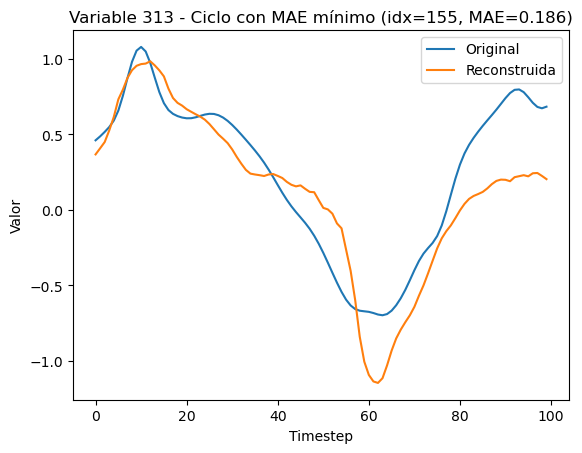

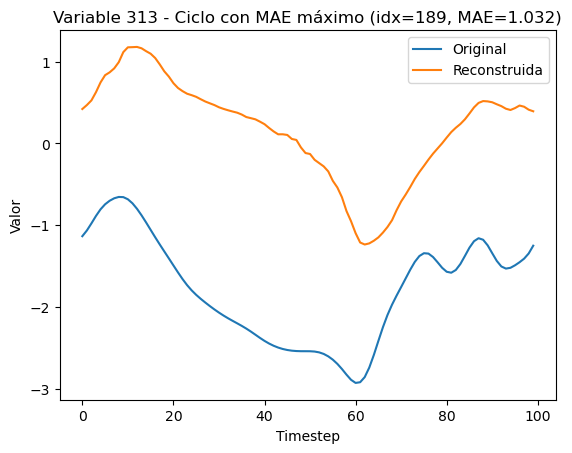

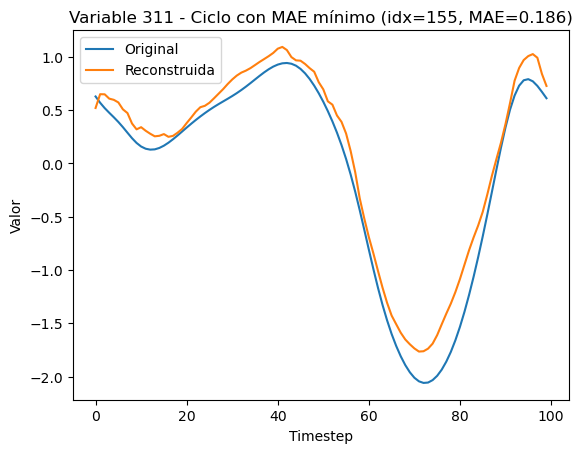

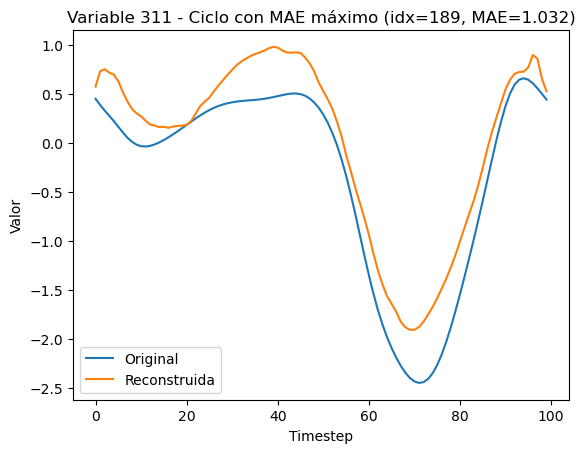

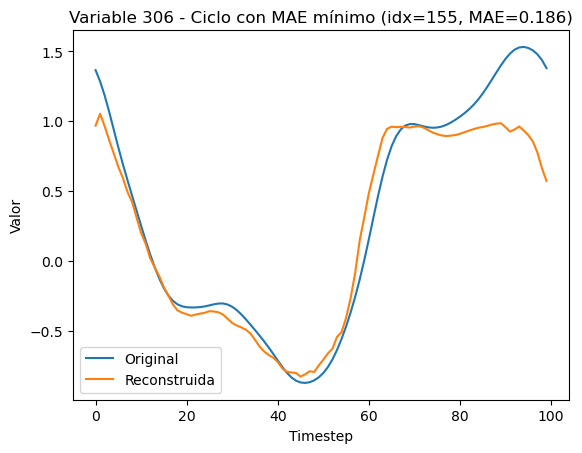

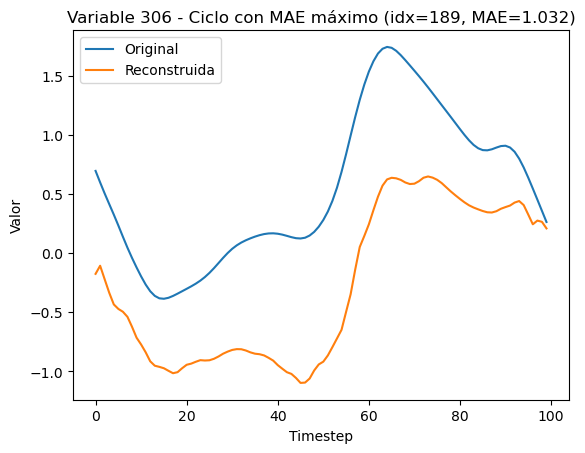

In [ ]:
# Plots the reconstruction for best and worse 

selected_vars = [313, 311, 306]
MAX_CYCLES = 200
BATCH_SIZE = 16
flat_ds = test_ds.unbatch()
sample_ds = flat_ds.shuffle(10000, seed=42).take(MAX_CYCLES).batch(BATCH_SIZE)


orig_cycles = []
recon_cycles = []
mae_cycles = []

for batch_x, _ in sample_ds:
    latents = encoder(batch_x, training=False)
    batch_recon = decoder(latents, training=False).numpy()
    
    x_orig = batch_x.numpy()[..., selected_vars]
    x_rec = batch_recon[..., selected_vars]
    
    err = np.abs(x_orig - x_rec)
    mae_batch = np.mean(err, axis=(1,2))
    
    orig_cycles.append(x_orig)
    recon_cycles.append(x_rec)
    mae_cycles.append(mae_batch)

# 
orig_cycles = np.concatenate(orig_cycles, axis=0)
recon_cycles = np.concatenate(recon_cycles, axis=0)
mae_cycles = np.concatenate(mae_cycles, axis=0)

# 
idx_min = np.argmin(mae_cycles)
idx_max = np.argmax(mae_cycles)

T = orig_cycles.shape[1]

# 
for i, var in enumerate(selected_vars):
    # 
    plt.figure()
    plt.plot(range(T), orig_cycles[idx_min, :, i], label="Original")
    plt.plot(range(T), recon_cycles[idx_min, :, i], label="Reconstruida")
    plt.title(f"Variable {var} - Ciclo con MAE mínimo (idx={idx_min}, MAE={mae_cycles[idx_min]:.3f})")
    plt.xlabel("Timestep")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()
    
    # 
    plt.figure()
    plt.plot(range(T), orig_cycles[idx_max, :, i], label="Original")
    plt.plot(range(T), recon_cycles[idx_max, :, i], label="Reconstruida")
    plt.title(f"Variable {var} - Ciclo con MAE máximo (idx={idx_max}, MAE={mae_cycles[idx_max]:.3f})")
    plt.xlabel("Timestep")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()


# Clustering 

In [9]:
#Crear el test_ds con labels 
# 1) Define los sujetos y rutas
test_npy_map = {}
test_subjects = {
    "G01": load_subjects_from_json("G01_test_subjects.json"),
    "G03": load_subjects_from_json("G03_test_subjects.json")
}
for group, subjects in test_subjects.items():
    paths_list = get_all_npy_paths_by_group({group: subjects}, base_folders)
    test_npy_map[group] = paths_list
    print(f"{group}: {len(paths_list)} archivos .npy")
    total_cycles = sum(
        np.load(p).shape[0]
        for p in paths_list
    )
    print(f"  → {total_cycles} ciclos en total")

# 3) Escribe el TFRecord de evaluación
label_map = {"G01": 0, "G03": 1}
write_labeled_tfrecord(
    test_npy=test_npy_map,
    output_tfrecord="test_cycles_labeled.tfrecord.gz",
    label_map  = label_map,
    n_timesteps=100,
    n_vars=321,
)



G01: 72 archivos .npy
  → 14980 ciclos en total
G03: 97 archivos .npy
  → 20135 ciclos en total
TFRecord etiquetado creado en: test_cycles_labeled.tfrecord.gz


In [11]:
# 4) Calls test_ds_labeled
from collections import Counter 
BATCH_SIZE = 32
test_ds_labeled = (
    tf.data.TFRecordDataset("test_cycles_labeled.tfrecord.gz", compression_type="GZIP")
      .map(parse_for_eval)
      .batch(BATCH_SIZE)
)
# 3) Cuenta cuántos ciclos hay de cada etiqueta
label_counter = Counter()
for _, batch_labels in test_ds_labeled:
    # batch_labels es un vector de ints
    label_counter.update(batch_labels.numpy().tolist())

print("Distribución en test_ds_labeled:", dict(label_counter))

Distribución en test_ds_labeled: {0: 14980, 1: 20135}


2025-06-19 19:07:50.710583: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Clustering accuracy: 0.623


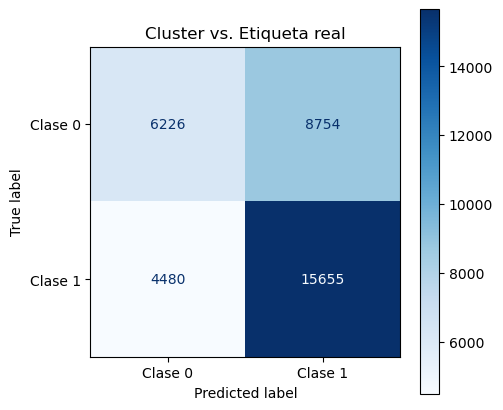

              precision    recall  f1-score   support

     Clase 0       0.58      0.42      0.48     14980
     Clase 1       0.64      0.78      0.70     20135

    accuracy                           0.62     35115
   macro avg       0.61      0.60      0.59     35115
weighted avg       0.62      0.62      0.61     35115

Adjusted Rand Index:         0.058
Normalized Mutual Information: 0.033


In [12]:
#Confusion matrix for label group 
N_CLUSTERS   = 2
RANDOM_STATE = 0
# 1) Inicializa contenedores
latents_list     = []
true_labels_list = []

# 2) Itera el dataset y extrae latentes + etiquetas
for batch_data, batch_labels in test_ds_labeled:
    # batch_data: (bs,100,321), batch_labels: (bs,)
    z = encoder.predict_on_batch(batch_data)   # (bs, latent_dim)
    latents_list.append(z)
    true_labels_list.append(batch_labels.numpy())

# 3) Concatenar todo
latents     = np.concatenate(latents_list,     axis=0)  # (N, latent_dim)
true_labels = np.concatenate(true_labels_list, axis=0)  # (N,)

# 4) Clustering
cluster_labels = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit_predict(latents)

# 5) Alineación de etiquetas de clúster (si es necesario)
acc = accuracy_score(true_labels, cluster_labels)
if acc < 0.5:
    cluster_labels = 1 - cluster_labels
    acc = 1 - acc
print(f"Clustering accuracy: {acc:.3f}")

# 6) Matriz de confusión
cm = confusion_matrix(true_labels, cluster_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=[f"Clase {i}" for i in range(N_CLUSTERS)])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(cmap="Blues", ax=ax, values_format="d")
plt.title("Confusión: Cluster vs. Etiqueta real")
ax.set_title("Cluster vs. Etiqueta real")
plt.show()

# Reporte más detallado
print(classification_report(
    true_labels, cluster_labels,
    target_names=[f"Clase {i}" for i in range(N_CLUSTERS)]
))

ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
print(f"Adjusted Rand Index:         {ari:.3f}")
print(f"Normalized Mutual Information: {nmi:.3f}")